In [38]:
library(goseq)
# library(Seurat)
library(stringr)

Loading required package: BiasedUrn
Loading required package: geneLenDataBase



In [36]:
geneinfo = read.table("/publicdata/gencode_v19_20151104/gene_info.tsv", sep = "\t", header = T)

In [98]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

In [41]:
plot_go_barplots <- function(table, t){
    
    par(mar = c(8, 15, 2, 1))
    
    if(length(table[table$bh == 0, ]$bh) > 0){
        table[table$bh == 0, ]$bh = 10e-100
    }

    
    barplot(-log(table$bh[10:1], 10), names.arg=table$term[10:1], horiz=T, main=t,
            las=1, cex.axis=1, cex.names=1.1)
    abline(v=1.3, lwd=2, lty=2, col="red")
    
}

In [37]:
## GO enrichment
FindGOenrichment <- function(genes, all.genes){
    
    list1 = genes
    list2 = all.genes

    genes_data = data.frame(gene = list2, inlist = 0, stringsAsFactors = FALSE)
    genes_data[genes_data$gene %in% list1, "inlist"] = 1
    genes_data$gene_id = str_split_fixed(genes_data$gene, "\\.", 2)[,1]
    genes_data = genes_data[!duplicated(genes_data$gene_id),]
    rownames(genes_data) = genes_data$gene_id
    genes_data$gene_id = NULL

    genes = genes_data$inlist
    names(genes) = rownames(genes_data)
    pwf=nullp(genes,"hg19", "ensGene", plot.fit = FALSE)
    gowall=goseq(pwf,"hg19","ensGene")

    gowall = gowall[gowall$numInCat > 10 & gowall$numInCat < 1000,]
    
    gowall$list1      = length(genes_data[genes_data$inlist == 1, "inlist"])
    gowall$list2      = length(genes_data[genes_data$inlist == 0, "inlist"])
    gowall$pvalue     = apply(gowall[, c("over_represented_pvalue", "under_represented_pvalue")], 1, min)
    gowall$bonferroni = p.adjust(gowall$pvalue, method = "bonferroni")
    gowall$bh         = p.adjust(gowall$pvalue, method = "BH")
    gowall_ordered <- gowall[order(gowall$over_represented_pvalue),]
    
    return(gowall_ordered)
    
}

In [101]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.analyzed.filtered.clustered", sep = "")
load(f, verbose = T)

Loading objects:
  tiss.filtered


In [99]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
f = paste(out, "obj.integrated.frazer.melton_cluster0_seurat_obj", sep = "")
load(f, verbose = T)

Loading objects:
  integrated.C0_test


In [102]:
bg = rownames(integrated.C0_test)
bg = geneinfo[geneinfo$gene_name %in% bg, "gene_id"]

# Visualize PPC data

In [100]:
integrated_meta = read.table(paste(out, "integrated_annotations.txt", sep = ""))

In [103]:
tiss.filtered@meta.data$major_cell_population = integrated_meta[match(rownames(tiss.filtered@meta.data), rownames(integrated_meta)), "major_cell_population"] 
tiss.filtered@meta.data$minor_cell_population = integrated_meta[match(rownames(tiss.filtered@meta.data), rownames(integrated_meta)), "minor_cell_population"] 

In [104]:
tiss.filtered@meta.data[tiss.filtered@meta.data$seurat_clusters == 2, ]$major_cell_population <- "iPSC"
tiss.filtered@meta.data[tiss.filtered@meta.data$seurat_clusters == 7, ]$major_cell_population <- "Endocrine"
tiss.filtered@meta.data[tiss.filtered@meta.data$seurat_clusters == 8, ]$major_cell_population <- "Endothelial"

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

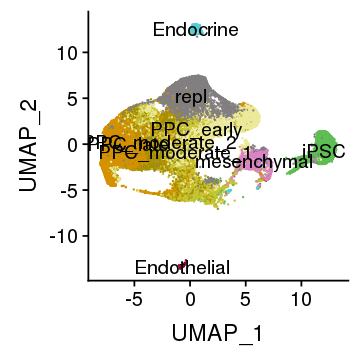

In [105]:
cols = data.frame(celltype = sort(unique(tiss.filtered$major_cell_population)),
                  col = c("#56ccd8", "#9c0031", "#5ebd53", "#d984c6", "#ede99a", "#d49100", "#c9c230", "#a39000", "#827f80"))
options(repr.plot.width = 3, repr.plot.height = 3)
DimPlot(tiss.filtered, reduction = "umap", group.by = "major_cell_population", cols = cols$col, label = T) + NoLegend()

In [106]:
save(tiss.filtered, file = paste(out, "obj.analyzed.filtered.clustered_finalAnnotation", sep = ""))

In [327]:
write.table(tiss.filtered@meta.data, file = paste(out, "frazer_study_cells_annotations_191113.txt", sep = ""))

# Calculate DE for all clusters (iPSC, all PPCs, repl, endocrine, endothelial, mesenchymal)

In [ ]:
tiss.filtered

In [248]:
Idents(tiss.filtered) <- "major_cell_population"

In [124]:
iPSC_markers <- FindMarkers(tiss.filtered, ident.1 = "iPSC", ident.2 = NULL, min.pct
z = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(iPSC_markers, file = paste(out, "iPSC_markers.txt", sep = ""))

In [125]:
repl_markers <- FindMarkers(tiss.filtered, ident.1 = "repl", ident.2 = NULL, min.diff.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(repl_markers, file = paste(out, "repl_markers.txt", sep = ""))

In [ ]:
mesenchymal_markers <- FindMarkers(tiss.filtered, ident.1 = "mesenchymal", ident.2 = NULL, min.diff.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(mesenchymal_markers, file = paste(out, "mesenchymal_markers.txt", sep = ""))

In [ ]:
Endocrine_markers <- FindMarkers(tiss.filtered, ident.1 = "Endocrine", ident.2 = NULL, min.diff.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(Endocrine_markers, file = paste(out, "Endocrine_markers.txt", sep = ""))

In [ ]:
endothelial_markers <- FindMarkers(tiss.filtered, ident.1 = "endothelial", ident.2 = NULL, min.diff.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(endothelial_markers, file = paste(out, "endothelial_markers.txt", sep = ""))

In [ ]:
ppc_markers <- FindMarkers(tiss.filtered, ident.1 = c("PPC_early", "PPC_moderate_1", "PPC_moderate_2", "PPC_late"),
                                   ident.2 = NULL, min.diff.pct = 0.25)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(ppc_markers, file = paste(out, "all.ppc_markers.txt", sep = ""))

# GO analysis on DE genes

In [304]:
GoWrapper <- function(marker.df){
    
    marker.df.id = geneinfo[geneinfo$gene_name %in% rownames(marker.df), "gene_id"]
    gowall = FindGOenrichment(marker.df.id, bg)
    return(gowall)
    
}

In [316]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

iPSC_markers = read.table(paste(out, "iPSC_markers.txt", sep = ""))

repl_markers = read.table(paste(out, "repl_markers.txt", sep = ""))

mesenchymal_markers = read.table(paste(out, "mesenchymal_markers.txt", sep = ""))

Endocrine_markers = read.table(paste(out, "Endocrine_markers.txt", sep = ""))

endothelial_markers = read.table(paste(out, "endothelial_markers.txt", sep = ""))

ppc_markers = read.table(paste(out, "all.ppc_markers.txt", sep = ""))

In [ ]:
bg = rownames(tiss.filtered)
bg = geneinfo[geneinfo$gene_name %in% bg, "gene_id"]

In [317]:
gowall_ipsc        = suppressWarnings(GoWrapper(iPSC_markers))
gowall_repl        = suppressWarnings(GoWrapper(repl_markers))
gowall_mesenchyme  = suppressWarnings(GoWrapper(mesenchymal_markers))
gowall_endocrine   = suppressWarnings(GoWrapper(Endocrine_markers))
gowall_endothelial = suppressWarnings(GoWrapper(endothelial_markers))
gowall_ppc         = suppressWarnings(GoWrapper(ppc_markers))

Loading hg19 length data...
Fetching GO annotations...
For 37644 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Loading hg19 length data...
Fetching GO annotations...
For 37644 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Loading hg19 length data...
Fetching GO annotations...
For 37644 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15

In [ ]:
# out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"

# write.table(gowall_ipsc,         file = paste(out, "gowall_ipsc.txt", sep = ""))
# write.table(gowall_repl,         file = paste(out, "gowall_repl.txt", sep = ""))
# write.table(gowall_mesenchyme,   file = paste(out, "gowall_mesenchyme.txt", sep = ""))
# write.table(gowall_endocrine,    file = paste(out, "gowall_endocrine.txt", sep = ""))
# write.table(gowall_endothelial,  file = paste(out, "gowall_endothelial.txt", sep = ""))
# write.table(gowall_ppc,          file = paste(out, "gowall_ppc.txt", sep = ""))

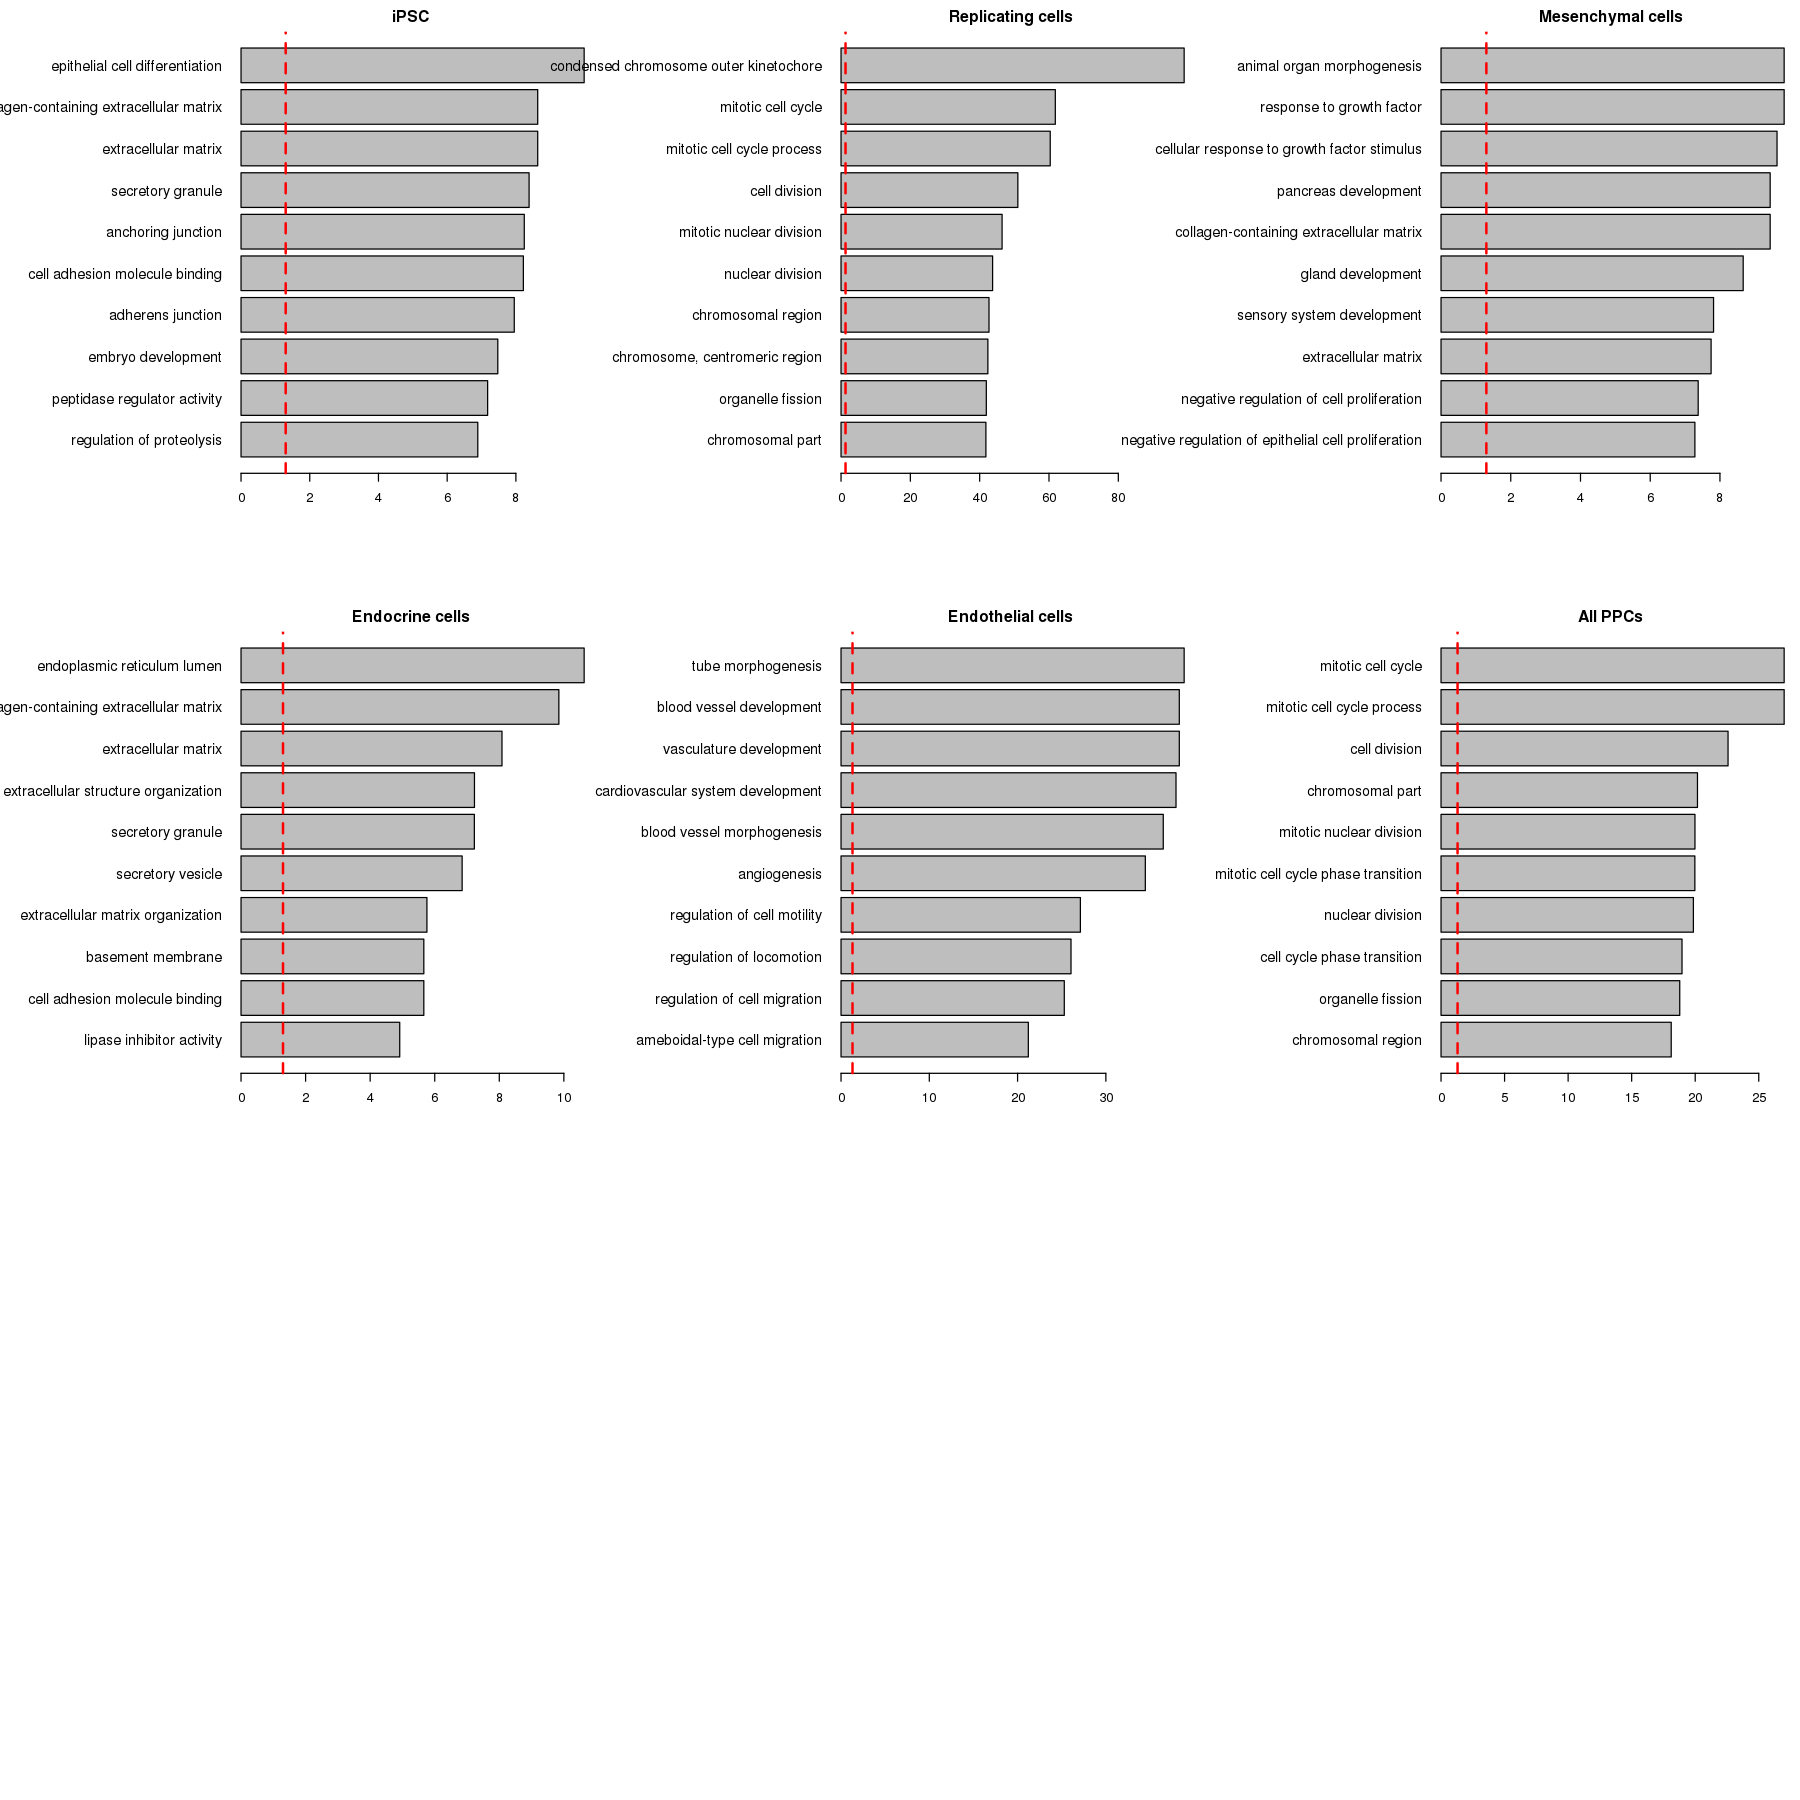

In [318]:
par(mfrow = c(3,3))
options(repr.plot.width = 15, repr.plot.height = 15)

plot_go_barplots(gowall_ipsc       , "iPSC")
plot_go_barplots(gowall_repl       , "Replicating cells")
plot_go_barplots(gowall_mesenchyme , "Mesenchymal cells")
plot_go_barplots(gowall_endocrine  , "Endocrine cells")
plot_go_barplots(gowall_endothelial, "Endothelial cells")
plot_go_barplots(gowall_ppc        , "All PPCs")

# Visualize PPC clusters

In [42]:
Idents(integrated.C0_test) <- "pseudotime_quantile"

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

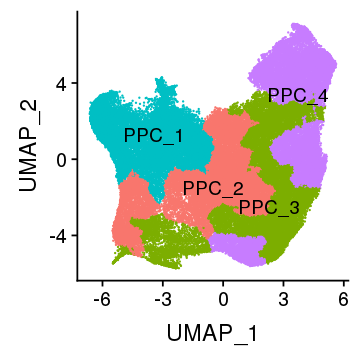

In [77]:
options(repr.plot.width = 3, repr.plot.height = 3)
DimPlot(integrated.C0_test, label = T) + NoLegend()

In [46]:
integrated.C0_test

ERROR: Error in eval(expr, envir, enclos): object 'integrated.C0_test' not found


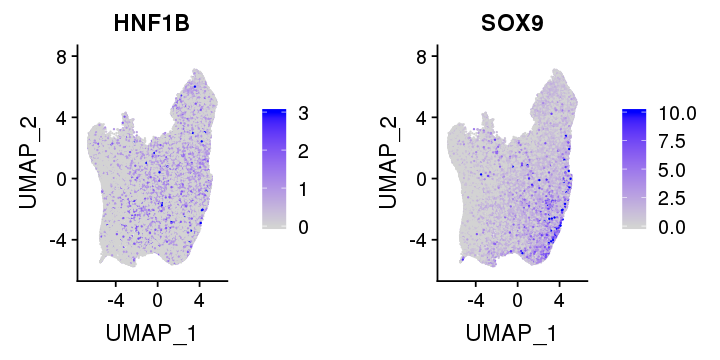

In [91]:
# https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002111#sec009
# "multipotent pancreatic progenitors" are PDX1+, HNF1B+, and SOX9+
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5470345/ 
#Expression of SOX9, which marks proliferative cells in a variety of tissues, distinguishes PDX1+ cells that will form the pancreas from those that give rise to other tissues
options(repr.plot.width = 6, repr.plot.height = 3)
FeaturePlot(integrated.C0_test, c("HNF1B", "SOX9"), max.cutoff = c(3, 10))

# Calculate DE genes from PPC 1-4 (integrated data)

In [ ]:
integrated.C0_test_PPC_1 <- FindMarkers(integrated.C0_test, ident.1 = "PPC_1", ident.2 = NULL, min.diff.pct = 0.15)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(integrated.C0_test_PPC_1, file = paste(out, "integrated_PPC_1_markers.txt", sep = ""))

In [43]:
integrated.C0_test_PPC_2 <- FindMarkers(integrated.C0_test, ident.1 = "PPC_2", ident.2 = NULL, min.diff.pct = 0.15)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(integrated.C0_test_PPC_2, file = paste(out, "integrated_PPC_2_markers.txt", sep = ""))

In [44]:
integrated.C0_test_PPC_3 <- FindMarkers(integrated.C0_test, ident.1 = "PPC_3", ident.2 = NULL, min.diff.pct = 0.15)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(integrated.C0_test_PPC_3, file = paste(out, "integrated_PPC_3_markers.txt", sep = ""))

In [45]:
integrated.C0_test_PPC_4 <- FindMarkers(integrated.C0_test, ident.1 = "PPC_4", ident.2 = NULL, min.diff.pct = 0.15)
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(integrated.C0_test_PPC_4, file = paste(out, "integrated_PPC_4_markers.txt", sep = ""))

# GO on PPC 1-4

In [6]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
integrated.C0_test_PPC_1 = read.table(paste(out, "integrated_PPC_1_markers.txt", sep = ""))

In [29]:
integrated.C0_test_PPC_1_markers = geneinfo[geneinfo$gene_name %in% rownames(integrated.C0_test_PPC_1), "gene_id"]

In [49]:
integrated.C0_test_PPC_2_markers = geneinfo[geneinfo$gene_name %in% rownames(integrated.C0_test_PPC_2), "gene_id"]

In [50]:
integrated.C0_test_PPC_3_markers = geneinfo[geneinfo$gene_name %in% rownames(integrated.C0_test_PPC_3), "gene_id"]

In [51]:
integrated.C0_test_PPC_4_markers = geneinfo[geneinfo$gene_name %in% rownames(integrated.C0_test_PPC_4), "gene_id"]

In [48]:
gowall = FindGOenrichment(integrated.C0_test_PPC_1_markers, bg)

In [52]:
gowall2 = FindGOenrichment(integrated.C0_test_PPC_2_markers, bg)

Loading hg19 length data...
Warning message in pcls(G):
“initial point very close to some inequality constraints”Fetching GO annotations...
For 37644 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [53]:
gowall3 = FindGOenrichment(integrated.C0_test_PPC_3_markers, bg)

Loading hg19 length data...
Fetching GO annotations...
For 37644 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [54]:
gowall4 = FindGOenrichment(integrated.C0_test_PPC_4_markers, bg)

Loading hg19 length data...
Warning message in pcls(G):
“initial point very close to some inequality constraints”Fetching GO annotations...
For 37644 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


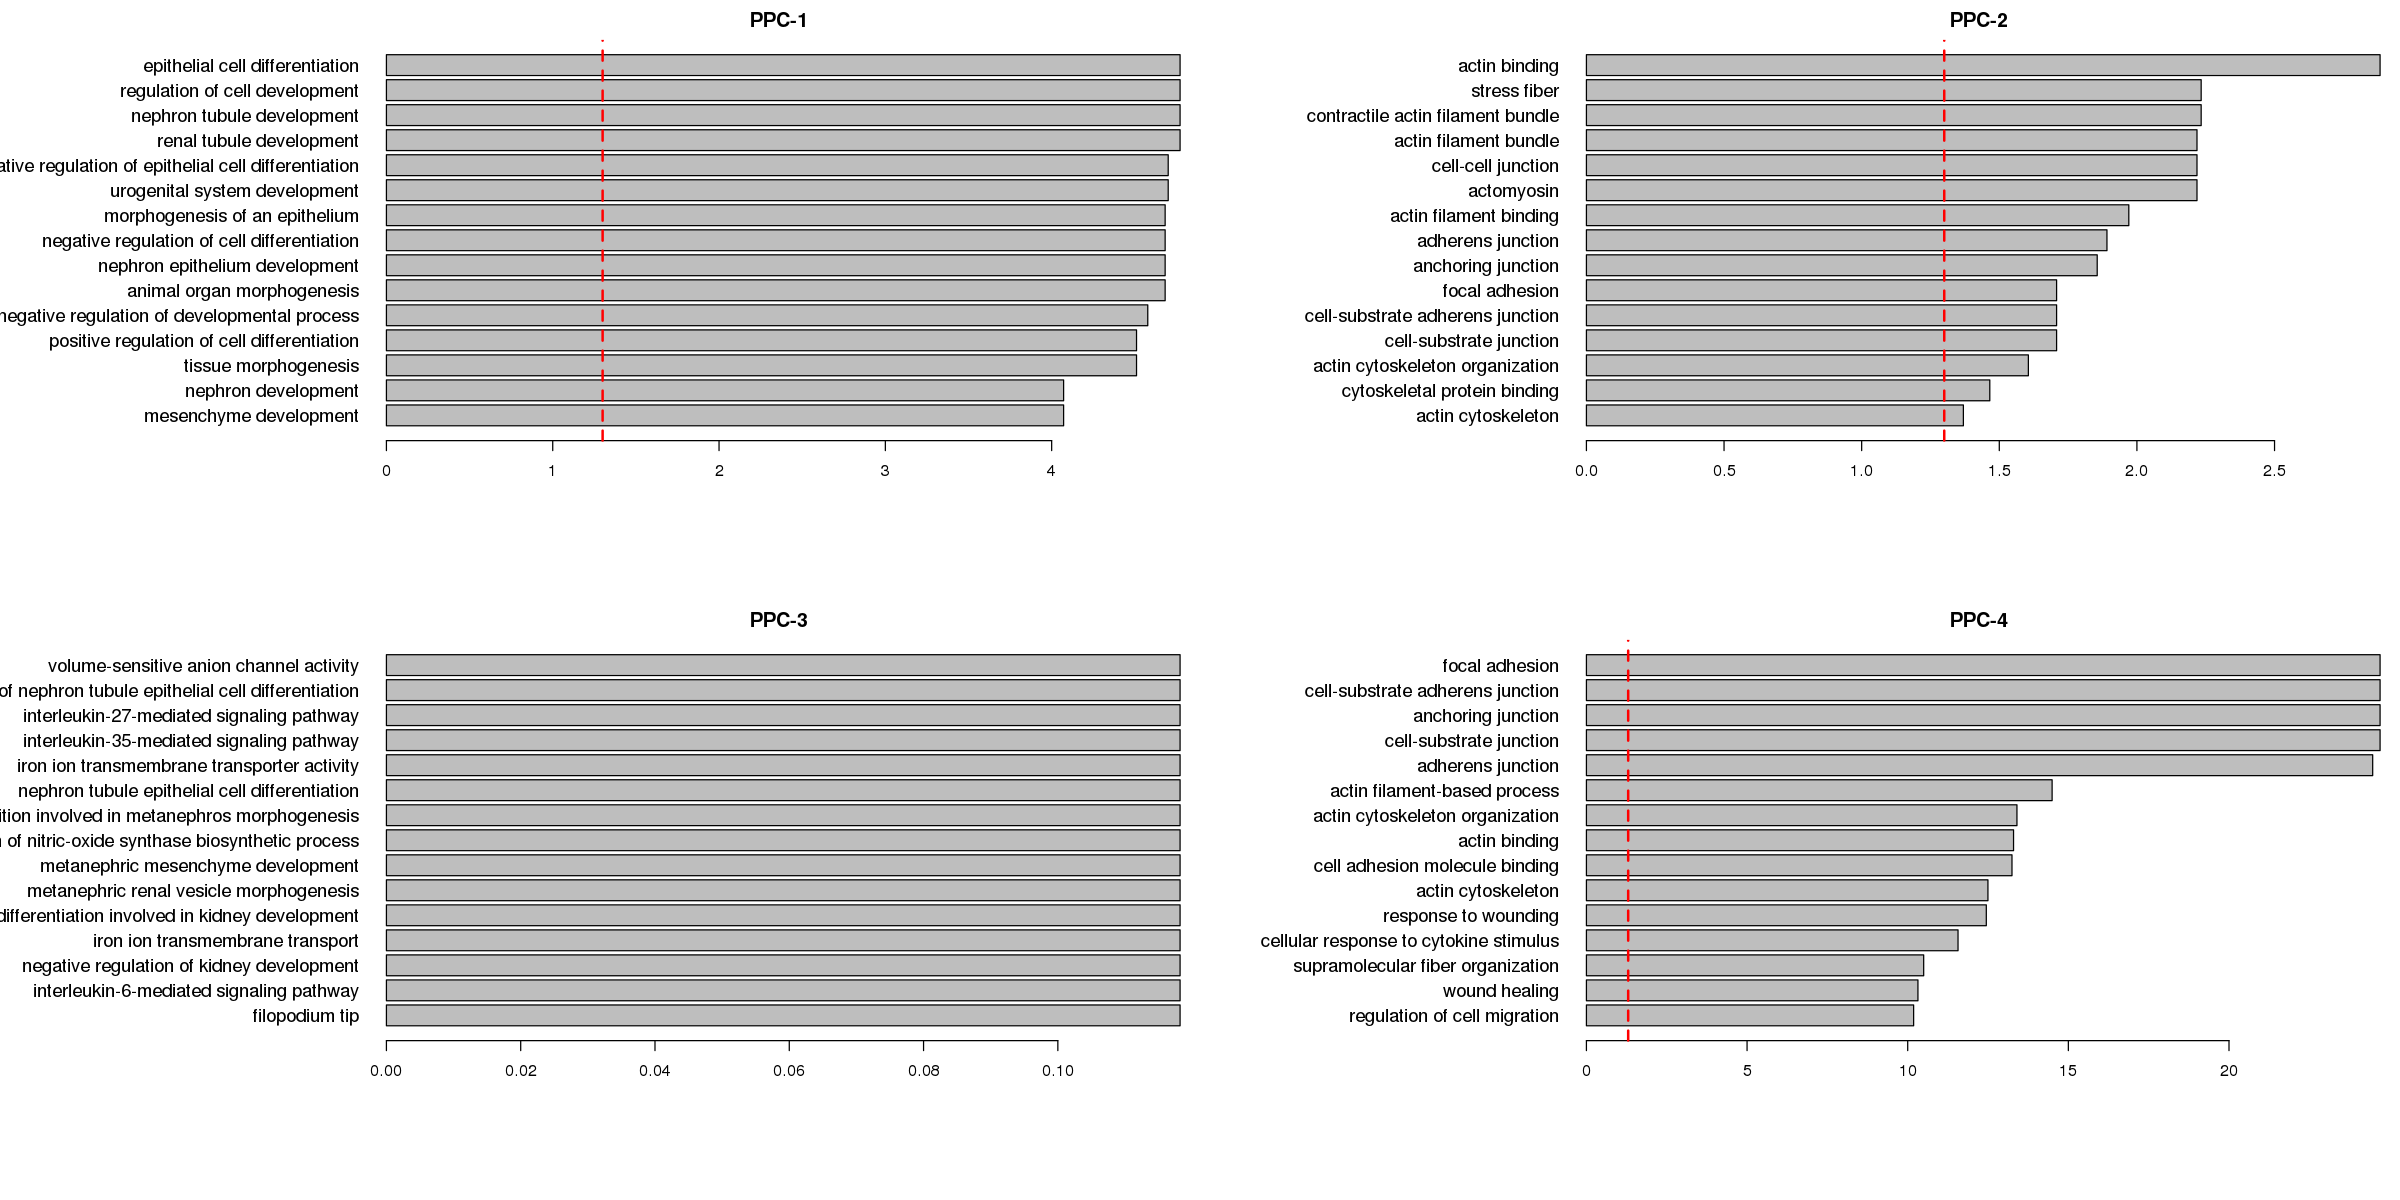

In [74]:
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow = c(2,2))
plot_go_barplots(gowall, "PPC-1")
plot_go_barplots(gowall2, "PPC-2")
plot_go_barplots(gowall3, "PPC-3")
plot_go_barplots(gowall4, "PPC-4")

#### Conclusion

early PPC are differentiating (i.e. "early"), but later PPC over express adhesion, wound healing, etc. because they are proliferating, which is characteristic of PPCs (PDX1+/NKX6-1+/SOX9+) primed for endocrine enduction

# Analyze ONLY Frazer PPCs

### Variable features in PPCs

In [249]:
tiss.filtered_ppc =  subset(tiss.filtered, idents = c("PPC_moderate_1", "PPC_moderate_2", "PPC_early", "PPC_late"))

In [251]:
tiss.filtered_ppc <- FindVariableFeatures(tiss.filtered_ppc, selection.method = "vst", nfeatures = 2000)

When using repel, set xnudge and ynudge to 0 for optimal results
Warning message:
“Transformation introduced infinite values in continuous x-axis”

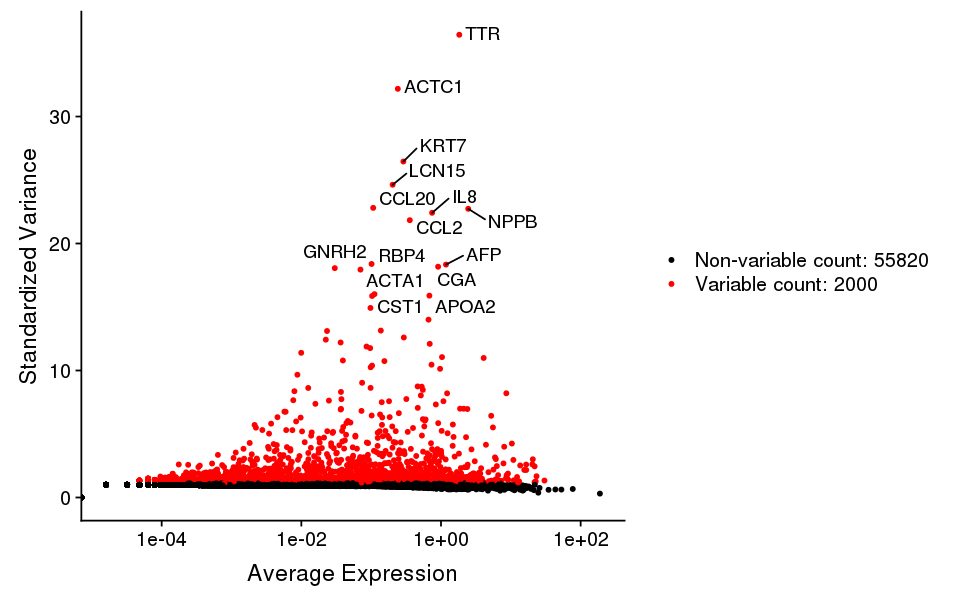

In [254]:
options(repr.plot.width = 8, repr.plot.height = 5)

top10 <- head(VariableFeatures(tiss.filtered_ppc), 15)
plot1 <- VariableFeaturePlot(tiss.filtered_ppc)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

# How do these DE genes change over time? 

In [10]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
load(paste(out, "obj.integrated.frazer.melton_cluster0_pseudotime", sep = ""), verbose = T)
cds

In [9]:
pData(cds)$pseudotime_bin = integrated_meta[match(rownames(pData(cds)), rownames(integrated_meta)), "major_cell_population"] 

ERROR: Error in eval(expr, envir, enclos): object 'integrated_meta' not found


In [11]:
# bin time by quantiles
pseudotime_ppc = as.data.frame(pseudotime(cds))
colnames(pseudotime_ppc) = "pseudotime"
quants = as.data.frame(quantile(pseudotime_ppc$pseudotime))

pseudotime_ppc$quants = NA
pseudotime_ppc$pseudotime = as.numeric(pseudotime_ppc$pseudotime)

pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[1, 1] & pseudotime_ppc$pseudotime <= quants[2, 1],  "quants" ] = "PPC_1"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[2, 1] & pseudotime_ppc$pseudotime <= quants[3, 1],  "quants" ] = "PPC_2"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[3, 1] & pseudotime_ppc$pseudotime <= quants[4, 1],  "quants" ] = "PPC_3"
pseudotime_ppc[pseudotime_ppc$pseudotime >= quants[4, 1] & pseudotime_ppc$pseudotime <= quants[5, 1],  "quants" ] = "PPC_4"


pData(cds)$pseudotime_quantile = pseudotime_ppc[match(rownames(pData(cds)), rownames(pseudotime_ppc)), "quants"]

In [13]:
pData(cds_subset)$RNA_snn_res.0.3 <- as.numeric(pData(cds_subset)$RNA_snn_res.0.3)

In [12]:
cds_subset <- cds[, colData(cds)$study %in% "Frazer"]

## Bin pseudotime into 20 bins (for speed up) and calculate mean expression per bin

In [400]:
data = cds_subset@assays$data$counts
bins = as.data.frame(pseudotime(cds_subset))
bins$bin = cut(bins[,1], breaks = 20, labels = FALSE)

In [ ]:
expressionBinned = data.frame(genes = rownames(data), bin_NA = NA)

for( pBin in unique(bins$bin)){
    
    cName = paste("bin", pBin, sep = "_")
    expressionBinned.temp = data.frame(genes = rownames(data),
                                       cName = rowMeans(as.data.frame(data[, colnames(data) %in% rownames(bins[bins$bin == pBin, ])])))
    colnames(expressionBinned.temp) <- c("genes", cName)
    
    expressionBinned = merge(expressionBinned, expressionBinned.temp, by="genes")
    
    
}

In [ ]:
expressionBinned$bin_NA <- NULL

In [ ]:
expressionBinned2model = as.data.frame(t(expressionBinned))
colnames(expressionBinned2model) <- expressionBinned2model[1,]
expressionBinned2model = expressionBinned2model[2:nrow(expressionBinned2model), ]

In [ ]:
expressionBinned2model$pseudotime_bin = as.numeric(str_split_fixed(rownames(expressionBinned2model), "_", 2)[,2])

In [ ]:
expressionBinned2model <- sapply( expressionBinned2model, as.numeric )
expressionBinned2model = expressionBinned2model[, colSums(expressionBinned2model != 0) > 0] # remove genes that have zero expression in all cells

In [ ]:
expressionBinned2model = as.data.frame(expressionBinned2model)

In [415]:
dim(expressionBinned2model)

[1]     4 34908

## fit a lm

In [169]:
test = expressionBinned2model[, c(1:10, ncol(expressionBinned2model))]

In [226]:
CalculateGLM <- function(j, df){
    
    fit <- lm( as.numeric(df[,j]) ~ as.numeric(df[, ncol(df)])) #, data=df,family=quasipoisson())
    gene = colnames(df)[j]
    return(data.frame(gene_short_name = gene,
                      term            = "pseudotime_bin",
                      estimate        = coef(summary(fit))[2,1],
                      std_err         = coef(summary(fit))[2,2],
                      p_value         = coef(summary(fit))[2,4]))
        
}

In [227]:
fit_coefs = data.frame(gene_short_name = NA, term = NA, estimate = NA, std_err = NA, p_value = NA)

for(i in seq(1, (ncol(expressionBinned2model) - 1))){
    
    fit_coefs = rbind(fit_coefs, CalculateGLM(i, expressionBinned2model))
}
fit_coefs = fit_coefs[2:nrow(fit_coefs), ]
fit_coefs$q_value = p.adjust(fit_coefs$p_value)

In [228]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(fit_coefs, file = paste(out, "ppc_fit_coefs_frazer_ppc_allexpressedgenes.txt", sep = ""))

# Analyze fit_coefs

In [239]:
# JAG1  https://www.ncbi.nlm.nih.gov/pubmed/19501159
# SPP1 (OPN) = marker of undifferentiated pancreatic precursors ; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2562505/

In [235]:
fit_coefs_sig = fit_coefs[fit_coefs$q_value < 0.05, ]

In [242]:
head(fit_coefs_sig[order(-abs(fit_coefs_sig$estimate)), ], 3)

,gene_short_name,term,estimate,std_err,p_value,q_value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
33462,VIM,pseudotime_bin,0.12241913,0.008653769,3.421823e-11,1.193361e-06
29522,SERPINA1,pseudotime_bin,0.10141631,0.011456866,5.633383e-08,1.941546e-03
30845,SPP1,pseudotime_bin,0.09917252,0.006138564,3.700090e-12,1.290888e-07


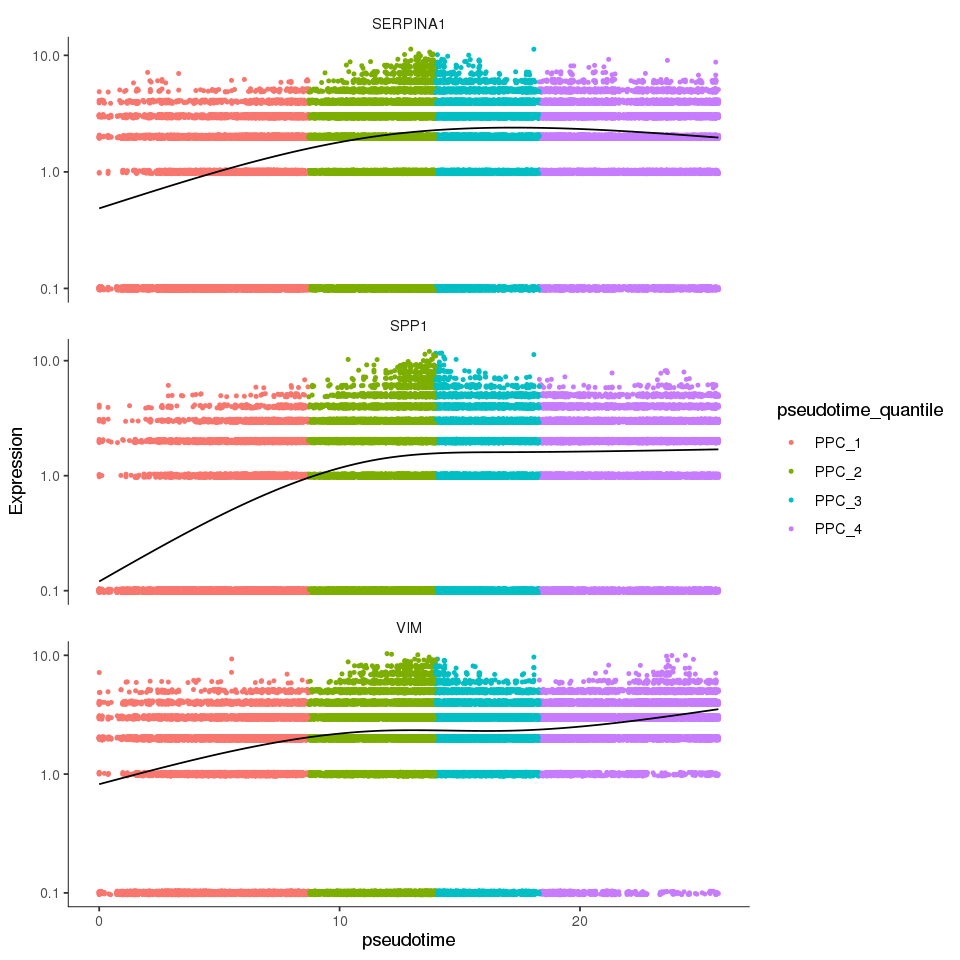

In [243]:
options(repr.plot.width = 8, repr.plot.height = 8)
plot_genes_in_pseudotime(cds_subset[rowData(cds_subset)$gene_short_name %in%
                                    head(fit_coefs_sig[order(-abs(fit_coefs_sig$estimate)), ], 3)$gene_short_name,], 
                         color_cells_by="pseudotime_quantile",
                         min_expr=0.1)

# Mfuzz to find non-linear changes in gene expression

In [416]:
expressionBinned2model2mfuzz = expressionBinned2model

In [418]:
rownames(expressionBinned2model2mfuzz) <- paste("time", expressionBinned2model2mfuzz$pseudotime_bin, sep = "_")

In [419]:
expressionBinned2model2mfuzz = as.data.frame(t(expressionBinned2model2mfuzz[order(rownames(expressionBinned2model2mfuzz)), ]))

In [421]:
write.table(expressionBinned2model2mfuzz, "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/ppc_expression_binpseudo4.txt")

In [4]:
load("/frazer01/home/jennifer/references/PPCs/mfuzz/out_4timepoints_10clusters.robj", verbose = T)

Loading objects:
  mfuzzOut


In [25]:
head(as.data.frame(mfuzzOut$membership))

,1,2,3,4,5,6,7,8,9,10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5S-rRNA.4,0.24137724,0.05110309,0.16279303,0.15458496,0.10099058,0.06155180,0.04730722,0.04940510,0.05085443,0.08003254
7SK,0.06292041,0.17695739,0.04825675,0.07995497,0.04470153,0.04805942,0.07268937,0.13748486,0.05865611,0.27031920
7SK.2,0.07022817,0.04268683,0.14396699,0.03966203,0.38975789,0.13700809,0.04756763,0.03920847,0.05241602,0.03749788
7SK.3,0.05148870,0.03940162,0.07522528,0.04264393,0.10203925,0.43304464,0.07262371,0.04959529,0.09653109,0.03740649
7SK.4,0.06436707,0.07854727,0.05352093,0.14004240,0.04962626,0.06225995,0.10967478,0.19062651,0.09914324,0.15219160
A1BG,0.28444596,0.06256461,0.10538507,0.16734458,0.07177436,0.04749768,0.04283785,0.05020863,0.04273132,0.12520994


In [26]:
memb = as.data.frame(mfuzzOut$membership)

In [27]:
memb$maxCol = colnames(memb)[apply(memb,1,which.max)]

In [28]:
memb$real = NA
for( i in seq(1, nrow(memb))){
    memb[i, "real"] = memb[i, memb[i, "maxCol"]] > 0.50   
}

In [29]:
table(memb$real, memb$maxCol)

       
           1   10    2    3    4    5    6    7    8    9
  FALSE 2565 2137 1610 2320 2166 2742 2534 2380 2668 2514
  TRUE   396  543 1547  904 1478 1719  545 1414  620 2106

In [30]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(memb, file = paste(out, "mfuzz_k10_b4_memberships.txt", sep = ""))

In [31]:
memb.real = memb[memb$real == TRUE,]

In [32]:
x = as.data.frame(table(memb.real$maxCol))
x = x[c(1, 3:10, 2),]
# x$Var1 = paste("cluster", x$Var1, sep = "_")

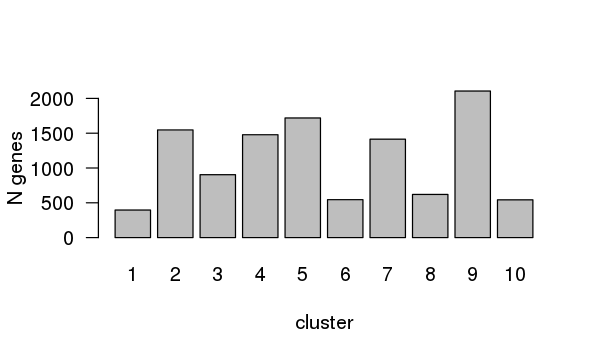

In [33]:
options(repr.plot.width = 5, repr.plot.height = 3)
barplot(x$Freq,las = 1, ylim = c(0, 2000), names.arg = x$Var1, xlab = "cluster", ylab = "N genes")

In [34]:
GoWrapperMfuzz <- function(cluster){
    
    bg = geneinfo[geneinfo$gene_name %in% rownames(memb), "gene_id"]
    memb.real_sub = memb.real[ memb.real$maxCol == cluster, ]
    marker.df.id = geneinfo[geneinfo$gene_name %in% rownames(memb.real_sub), "gene_id"]
    gowall = FindGOenrichment(marker.df.id, bg)
    return(gowall)
    
}

In [39]:
gowall2 = GoWrapperMfuzz(2)
gowall6 = GoWrapperMfuzz(6)

Loading hg19 length data...
Fetching GO annotations...
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, 

In [ ]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(gowall2, file = paste(out, "gowall_ppc_mid.up.txt", sep = ""))

write.table(gowall6, file = paste(out, "gowall_ppc_mid.down.txt", sep = ""))

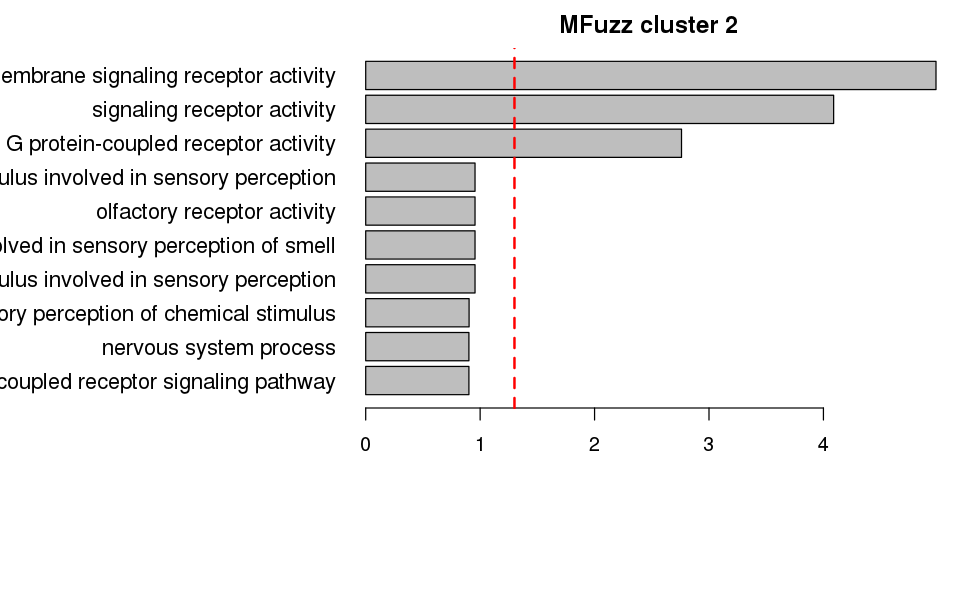

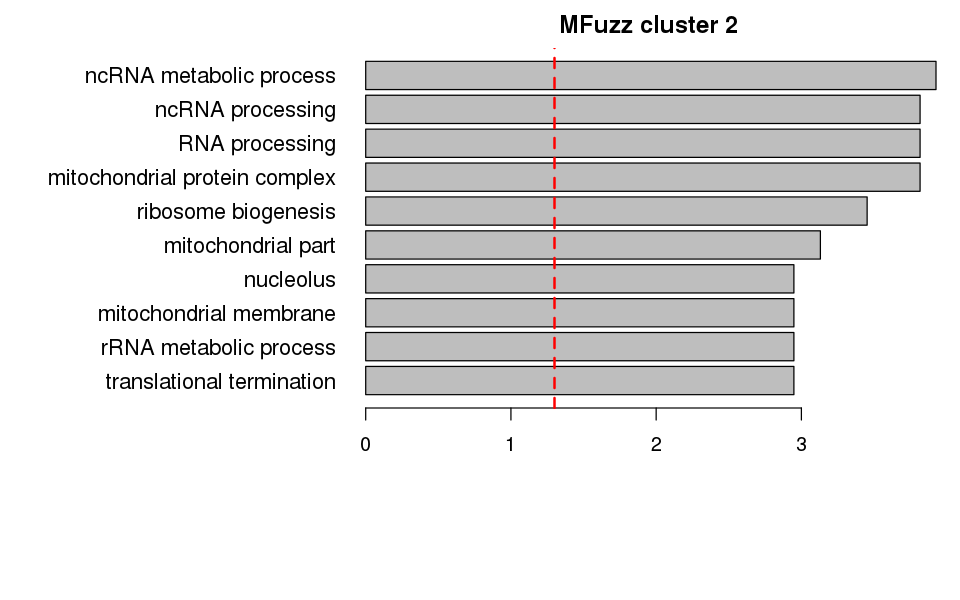

In [42]:
options(repr.plot.width = 8, repr.plot.height = 5)
plot_go_barplots(gowall2, "MFuzz cluster 2")
plot_go_barplots(gowall6, "MFuzz cluster 2")

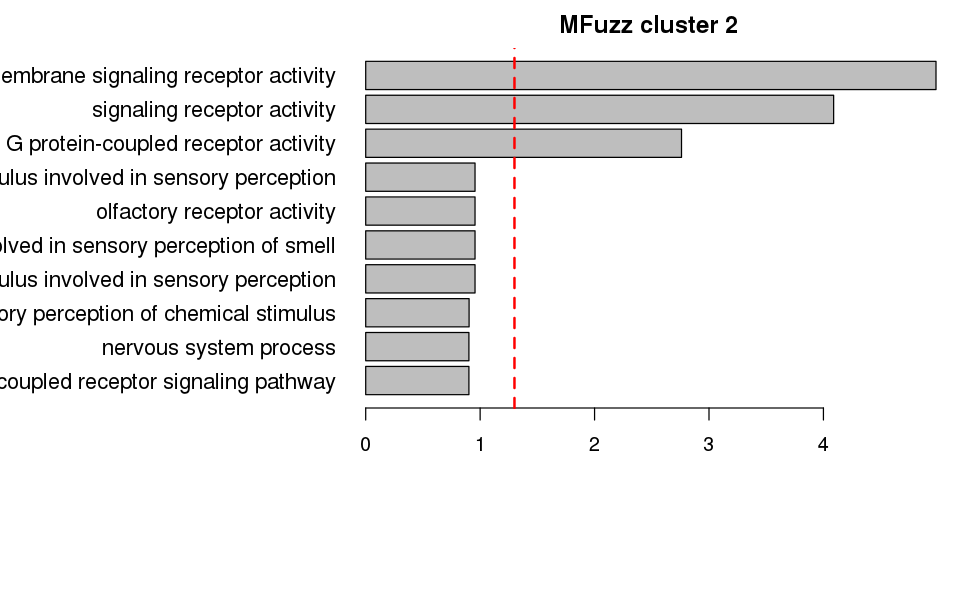

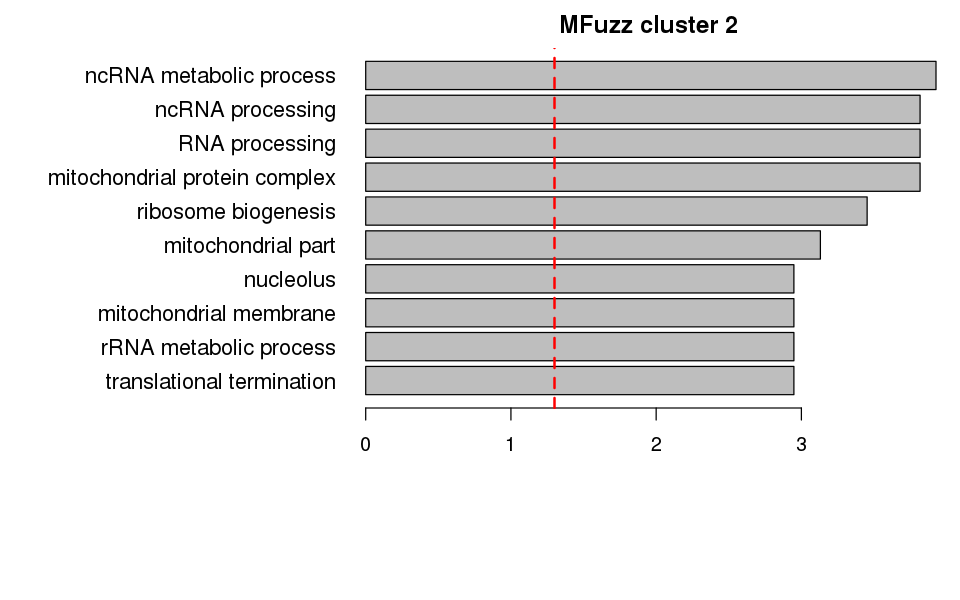

In [96]:
options(repr.plot.width = 8, repr.plot.height = 5)
plot_go_barplots(gowall2, "MFuzz cluster 2")
plot_go_barplots(gowall6, "MFuzz cluster 2")

# GSEA

In [289]:
suppressPackageStartupMessages(library(gage))

In [288]:
fit_coefs2gsea = fit_coefs[order(-(fit_coefs$estimate)), ]

In [291]:
read_gene_set_collection <- function (gene_set_collection = available_gene_sets()[[1]], gene_sets_folder = "/publicdata/MSigDB_20171129") 
{
    gene_set_file = paste(gene_sets_folder, "/", gene_set_collection, sep = "")
    dat = readLines(gene_set_file, warn = FALSE)
    dat = strsplit(dat, "\t")
    names(dat) = unlist(lapply(dat, function(x) {
        x[[1]]
    }))
    gene_set_names = rapply(dat, function(x) head(x, 1))
    gene_set_descriptions = rapply(dat, function(x) head(x, 2))[c(FALSE, 
        TRUE)]
    dat = lapply(dat, function(x) {
        x[-(1:2)]
    })
    return(list(gene_set_names, gene_set_descriptions, dat))
}
                                   
runGsea = function(exprs, gsets, set.size = c(0, 10000))
{
    gsea = gage(exprs = exprs, gsets = gsets,  set.size = set.size)
    
    greater    = as.data.frame(gsea$greater, stringsAsFactors = FALSE)
    less       = as.data.frame(gsea$less   , stringsAsFactors = FALSE)

    greater$id = rownames(greater)
    less$id    = rownames(less   )

    greater$pval_greater = greater$p.val
    greater$qval_greater = greater$q.val # BH correction
    less$pval_less       = less$p.val
    less$qval_less       = less$q.val    # BH correction

    out = merge(greater[, c("id", "stat.mean", "pval_greater", "qval_greater")], less[, c("id", "pval_less", "qval_less")])
    out = out[order(out$stat.mean, decreasing = TRUE),]
    
    out$pval = apply(out[,c("pval_greater", "pval_less")], 1, min)
    out$qval = apply(out[,c("qval_greater", "qval_less")], 1, min)
    
   return(out[,c("id", "stat.mean", "pval", "qval")])
}

In [359]:
# MSigDB 
gene_sets = c('c1.all.v6.1.symbols.gmt', 'c2.cp.biocarta.v6.1.symbols.gmt', 'c2.cp.kegg.v6.1.symbols.gmt',
              'c2.cp.reactome.v6.1.symbols.gmt', 'c3.mir.v6.1.symbols.gmt', 'c3.tft.v6.1.symbols.gmt',
              'c5.bp.v6.1.symbols.gmt', 'c5.cc.v6.1.symbols.gmt', 'c5.mf.v6.1.symbols.gmt',
              'h.all.v6.1.symbols.gmt', 'IPA_regulators.symbols.gmt', 
              'mitochondrial_genes.symbols.gmt')

In [360]:
gsea_msigdb_targeted = list()
counter = 1

for (file in gene_sets){

    gene_set_data = read_gene_set_collection(file,
                                             gene_sets_folder = "/publicdata/MSigDB_20171129")

    to_gsea   = fit_coefs2gsea[, c("gene_short_name", "estimate")]
    to_gsea <- aggregate(estimate ~ gene_short_name, data = to_gsea, FUN = mean)
    rownames(to_gsea) <- to_gsea$gene_short_name
    to_gsea$gene_short_name <- NULL
    to_gsea$value <- as.numeric(to_gsea$estimate)
    to_gsea$estimate <- NULL

    x = "" 
    for (i in gene_set_data[[1]]){
        x <- runGsea(exprs = to_gsea, gsets = gene_set_data[[3]])

    }
    gsea_msigdb_targeted[[counter]] <- x
    counter = counter + 1
}


In [361]:
all = data.frame(id = 1, stat.mean = 1, pval = 1, qval = 1)

for( i in seq(1, length(gsea_msigdb_targeted))){
    
    all = rbind(all, gsea_msigdb_targeted[[i]])

}

In [362]:
all = all[2:nrow(all),]

In [387]:
plot_go_barplots <- function(table, t){

    table$logq = -log(table$qval, 10)
    table[ table$stat.mean < 0, ]$logq = table[ table$stat.mean < 0, ]$logq*-1
    
    barplot(table$logq, names.arg=table$id, horiz=T, main=t,
            las=1, cex.axis=1, cex.names=0.5)
    abline(v=1.3, lwd=2, lty=2, col="red")
    abline(v=-1.3, lwd=2, lty=2, col="red")
    
}

In [388]:
all = all[order(all$qval), ]

In [ ]:
library(enrichplot)

In [ ]:
barplot(edo, showCategory=20)

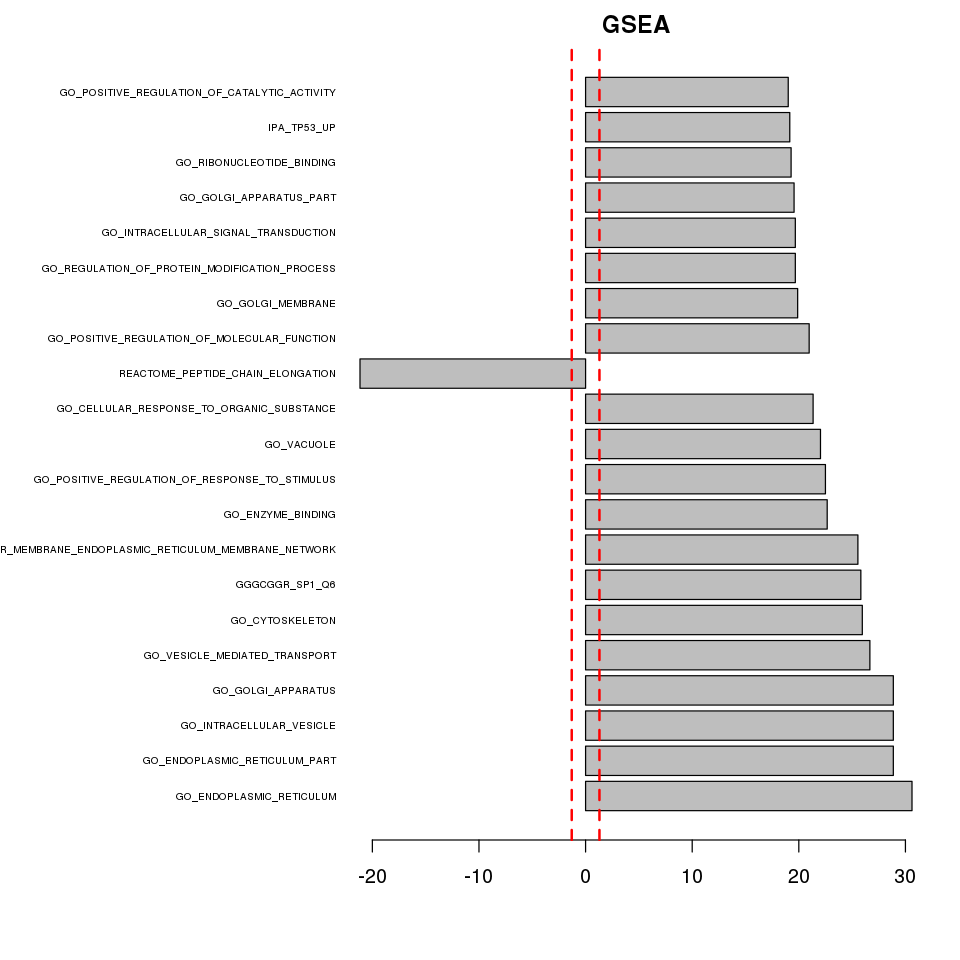

In [392]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mar = c(5, 15, 2, 2))
a = subset(all, qval < 10e-20)
plot_go_barplots(a[order(a$qval),], "GSEA")

In [365]:
out = "/projects/PPC/analysis/ppc_pilot/data/aggr_live_then_integrate/"
write.table(all, file = paste(out, "ppc_fit_coefs_frazer_ppc_allexpressedgenes_gsea.txt", sep = ""))